# Using resolved optical images for forced IR photometry

We will take a test case extended object from SDSS and convolve it with the Herschel SPIRE psf to be used for forced photometry with XID+.  

In [1]:
from regphot import git_version
print("This notebook was run with regphot version: \n{}".format(git_version()))

This notebook was run with regphot version: 
6adee20 (Tue May 9 12:17:27 2017 +0100) [with local modifications]


In [26]:
from regphot.utils import getPlateFits

from astropy.table import Table
from astropy.wcs import WCS
from astropy.io import fits
from astropy.coordinates import SkyCoord
from astropy.nddata import Cutout2D
from astropy.units import Quantity
from astropy.convolution import Gaussian2DKernel
from astropy.convolution import convolve #Deals with NaN better than scipy


import matplotlib.pyplot as plt
%matplotlib inline
import aplpy

#import scipy.signal as signal #To perform convolution
import numpy as np
from os import remove

In [27]:
# A single column of an xml table provided by Peter Hurley, which he has already run tests on.
testObject = Table.read('data/extended_source_test.xml')

In [28]:
testObject

Field,ID2MASX,RAJ2000,DEJ2000,supRAdeg,supDEdeg,density,r_K20e,J_K20e,e_J_K20e,f_J_K20e,H_K20e,e_H_K20e,f_H_K20e,K_K20e,e_K_K20e,f_K_K20e,Kb_a,Kpa,Sb_a,Spa,r_ext,J_ext,e_J_ext,H_ext,e_H_ext,K_ext,e_K_ext,cc
,,deg,deg,deg,deg,,arcs,mag,mag,,mag,mag,,mag,mag,,,deg,,deg,arcs,mag,mag,mag,mag,mag,mag,
object,object,float64,float64,float64,float64,float64,float64,float64,float64,int16,float64,float64,int16,float64,float64,int16,float64,int16,float64,int16,float64,float64,float64,float64,float64,float64,float64,object
XMM-LSS,02213646-0531170,35.401958,-5.5213939999999999,35.401961999999997,-5.5213799999999997,2.5499999999999998,51.0,10.523999999999999,0.024,0,9.9870000000000001,0.040000000000000001,0,9.6880000000000006,0.050999999999999997,0,0.66000000000000003,-60,0.47999999999999998,-70,86.959999999999994,10.145,0.024,9.7349999999999994,0.040000000000000001,9.4049999999999994,0.050999999999999997,0


In [29]:
#Use the very simple function from regphot to download fits image from SDSS
image = getPlateFits(str(testObject['RAJ2000'][0]) + 'd ' + str(testObject['DEJ2000'][0]) + 'd', 'i')
objid = str(testObject['ID2MASX'][0])[2:][:-1]
try:
    image[0].writeto('data/' + objid + '.fits')
except:
    remove('data/' + objid + '.fits')
    image[0].writeto('data/' + objid + '.fits')

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


INFO: Auto-setting vmin to -2.014e-01 [aplpy.core]
INFO: Auto-setting vmax to  8.860e-01 [aplpy.core]


/Users/rs548/anaconda/envs/herschelhelp_internal/lib/python3.6/site-packages/aplpy/wcs_util.py:515: UserWarning: Pixels are not square, using an average pixel scale
  warnings.warn("Pixels are not square, using an average pixel scale")


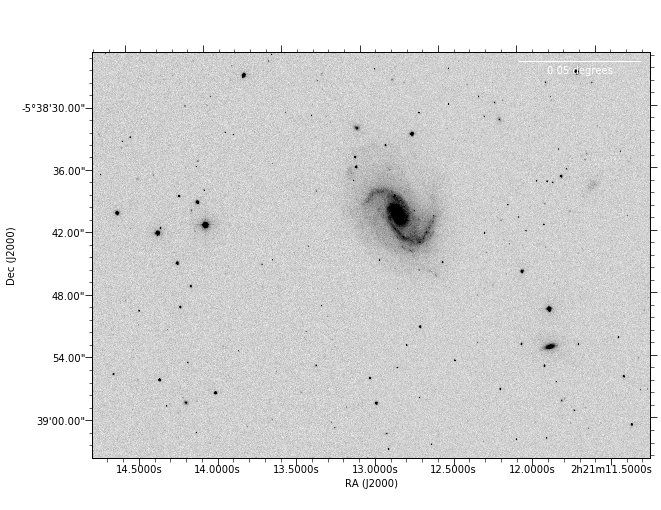

In [30]:
#Show the full fits plate to get an idea of how big a cutout to use
full = fits.open('data/' + objid + '.fits')
wcs = WCS('data/' + objid + '.fits')
apfig = aplpy.FITSFigure(full)
apfig.show_grayscale()
apfig.add_scalebar(0.05, "0.05 degrees", color='white', corner='top right')
apfig.set_theme('publication')
apfig.tick_labels.set_xformat('hh:mm:ss.ssss') #ddd.dddddd')
apfig.tick_labels.set_yformat('dd:mm:ss.ss') #ddd.dddddd')
apfig.ticks.show()
#apfig.ticks.set_xspacing(0.05)
apfig.tick_labels.show()
#apfig.add_grid()

## Cutout object
Based on inspecting the above object we should cutout around 0.05 degrees square. Ideally we cutout the smallest possible region to avoid including other objects. We intend to define a MOC around the object to prevent including catalogue objects which will be present in the image leading to degeneracy.

In [31]:
cutout = Cutout2D(full[0].data, 
                  SkyCoord(str(testObject['RAJ2000'][0]) + 'd ' + str(testObject['DEJ2000'][0]) + 'd'), 
                  Quantity('0.03 deg'),
                  mode='partial', 
                  fill_value=0.0, 
                  wcs=wcs)


In [32]:
full[0].data = cutout.data
#full[0].wcs = cutout.wcs
#full.header = cutout.wcs.to_header()
try:
    full.writeto('data/' + objid + '-cutout.fits')
except:
    remove('data/' + objid + '-cutout.fits')
    full.writeto('data/' + objid + '-cutout.fits')


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


INFO: Auto-setting vmin to -3.694e-01 [aplpy.core]
INFO: Auto-setting vmax to  3.729e+00 [aplpy.core]


/Users/rs548/anaconda/envs/herschelhelp_internal/lib/python3.6/site-packages/aplpy/wcs_util.py:515: UserWarning: Pixels are not square, using an average pixel scale
  warnings.warn("Pixels are not square, using an average pixel scale")


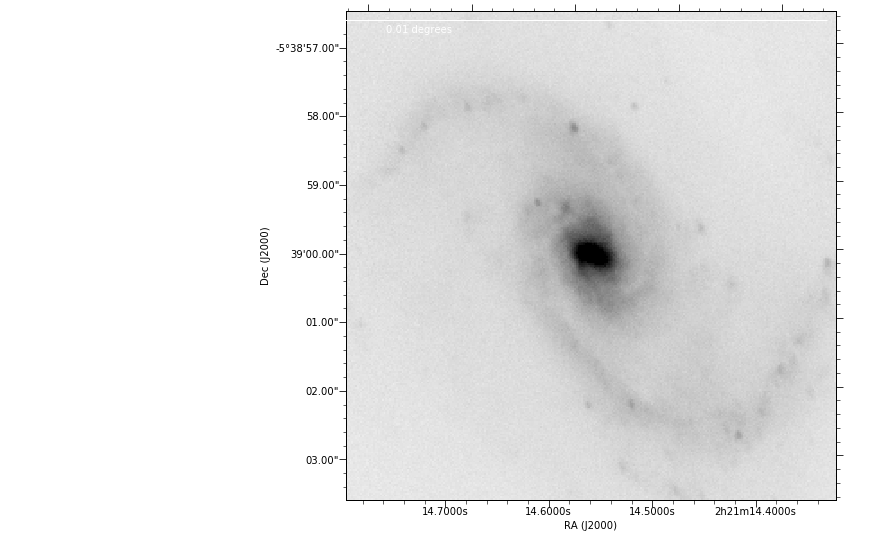

In [33]:

partial = fits.open('data/' + objid + '-cutout.fits')
apfig = aplpy.FITSFigure(partial)
apfig.show_grayscale()
apfig.add_scalebar(0.01, "0.01 degrees", color='white', corner='top right')
apfig.set_theme('publication')
apfig.tick_labels.set_xformat('hh:mm:ss.ssss') #ddd.dddddd')
apfig.tick_labels.set_yformat('dd:mm:ss.ss') #ddd.dddddd')
apfig.ticks.show()
#apfig.ticks.set_xspacing(0.05)
apfig.tick_labels.show()
#apfig.add_grid()

In [ ]:
#TODO - fix wcs problem - this image is not correctly located

## Produce MOC for region of image
We produce a MOC to cover the object, ideally covering the total area of the object but not including overlapping objects. In the future this stage could include a deblender.

In [ ]:
#Use pymoc to create a MOC of the cutout above or a circular MOC that is closer to the actual object

## Convolve the optical image with the infrared point spread function
Assuming the optical image is a similar shape to the IR image we convolve the resolved optical image with the known Gaussian PSF for the target IR image to create our final shape.

We will first convolve at the pixel scale of the optical image and then move to a different pixel scale?

In [ ]:
# First create a Gaussian kernel at the optical image pixel size

testsize = 10 # pixels
psftest = Gaussian2DKernel(testsize,x_size=101,y_size=101)
#psftest.normalize(mode='peak')

# Convolve optical image with psf
convolvedopt = convolve(cutout.data,psftest) #[::6,::6]

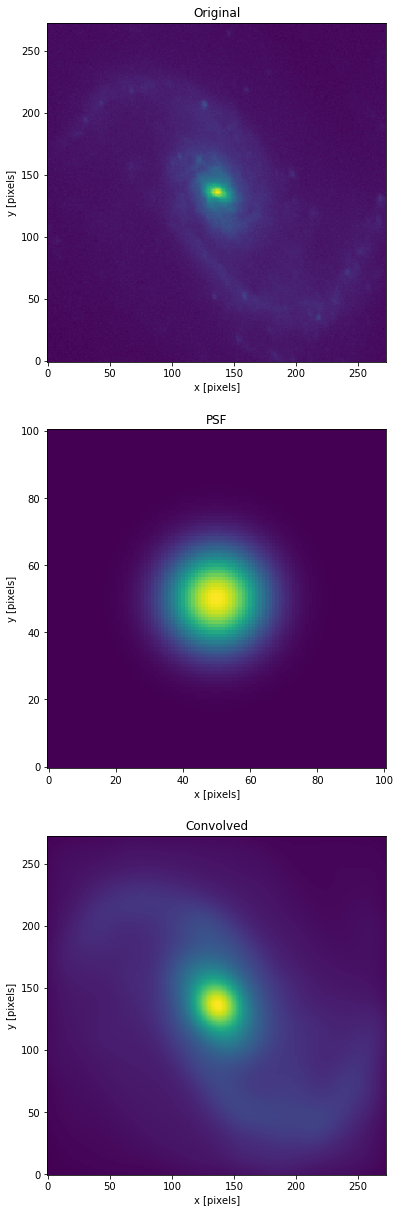

In [50]:
#Now plot the images

plt.subplot(3,1,1)
plt.imshow(cutout.data, interpolation='none', origin='lower')
plt.title('Original')
plt.xlabel('x [pixels]')
plt.ylabel('y [pixels]')

plt.subplot(3,1,2)
plt.imshow(psftest, interpolation='none', origin='lower')
plt.title('PSF')
plt.xlabel('x [pixels]')
plt.ylabel('y [pixels]')
#plt.colorbar()

plt.subplot(3,1,3)
plt.imshow(convolvedopt, interpolation='none', origin='lower')
plt.title('Convolved')
plt.xlabel('x [pixels]')
plt.ylabel('y [pixels]')
plt.subplots_adjust(left=0.0, right=1.0, bottom=0.0, top=4.0)

plt.show()

### Scale to correct pixel size
The pixel size of the image must match the pixel size of the target data.

### Produce images for 250, 350, and 500 micron targets

In [ ]:
pixsize250,pixsize350,pixsize500 = 1., 2., 3. #arcsec guesses off the top of my head

# This code is directly copied from Peter's example 
#pixsize array (size of pixels in arcseconds)
pixsize=np.array([pixsize250,pixsize350,pixsize500])
#point spread function for the three bands
psfsize=np.array([18.15,25.15,36.3])


##---------fit using Gaussian beam-----------------------
psf250=Gaussian2DKernel(psfsize[0]/2.355,x_size=101,y_size=101)
psf250.normalize(mode='peak')
psf350=Gaussian2DKernel(prfsize[1]/2.355,x_size=101,y_size=101)
psf350.normalize(mode='peak')
psf500=Gaussian2DKernel(prfsize[2]/2.355,x_size=101,y_size=101)
psf500.normalize(mode='peak')

pind250=np.arange(0,101,1)*1.0/pixsize[0] #get 250 scale in terms of pixel scale of map
pind350=np.arange(0,101,1)*1.0/pixsize[1] #get 350 scale in terms of pixel scale of map
pind500=np.arange(0,101,1)*1.0/pixsize[2] #get 500 scale in terms of pixel scale of map

convolved250 = convolve(psf250)[::6,::6]